[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tuankhoin/COMP90086-Practical-Solutions/blob/master/Week%205/workshop05_solution.ipynb)

# COMP90086 Week 5: Tensorflow 101

***
In this worksheet, we'll implement a Multilayer perceptron and convolutional neural network (CNN) in Keras—a high-level API for deep learning. We will use MNIST Dataset for experiments.


Table of Contents

- MNIST dataset

- Multilayer Perceptron
     
- Convolutional neural network with standard 2D convolution

- Visualize Filters and Feature Maps in CNN
     
- Bonus: Convolutional neural network with depthwise separable convolution
    

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')
path = "gdrive/My Drive/COMP90086 (T)/Week 5/"

Mounted at /content/gdrive


In [ ]:
# Imports
from datetime import datetime
from packaging import version

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt

print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.4.1


## "I want to use GPU on tensorflow"

OK OK! Check if your device has GPU ready first!

In [ ]:
# tf.test.is_gpu_available()
# tf.config.list_physical_devices('GPU')
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

When ready, tensorflow will prioritize using your GPU first. But in case you want to manually assign...
```python
# This prints out a log to help you check which task is allocated to which resource
tf.debugging.set_log_device_placement(True)

# Specify to do operation on CPU
with tf.device('/CPU:0'):
  a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

# Non-specified will run on the initial GPU by default
c = tf.matmul(a, b)
print(c)

# In case you still want to manually assign GPU (to make sure, or you have multiple of them)
with tf.device('/device:GPU:69'):
    a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
    b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
    c = tf.matmul(a, b)

# If what you specified doesn't exist, you can tell tensorflow to pick one for you
tf.debugging.set_log_device_placement(True)
```

Some good place to get started:
* [Tensorflow tutorial on using GPU](https://www.tensorflow.org/guide/gpu)
* [Colab tutorial on using GPU](https://colab.research.google.com/notebooks/gpu.ipynb)

## 1. MNIST dataset

MNIST is a dataset that consists of images of handwritten digits:
* the input data are images of handwritten digits (28×28 pixels with a single 8-bit channel)
* the target is a label in the set $\{0, 1, \ldots, 9\}$

The data is already split into training and test sets. The training set contains 60,000 instances and the test set contains 10,000 instances.

<center>Sample images from MNIST test dataset. (MNIST refers to *Modified National Institute of Standards and Technology*.)</center>

<img style="float: ;" src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png" width=500 height=300>

(Ref & Image Source: Wikipedia [MNIST database](https://en.wikipedia.org/wiki/MNIST_database))

Below we load the data into NumPy arrays using a built-in function from Keras.

Keras is an open-source deep learning library written in Python.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()
print("train_images shape:", train_images.shape)
print("test_images shape:", test_images.shape)

train_images shape: (60000, 28, 28)
test_images shape: (10000, 28, 28)


Before using the data for classification, we need to do some basic pre-processing: 
 * **Normalize**: rescale the images so that each pixel is represented as a float between 0 and 1
 * **Reshape**: transform the input to be a 4D input with number of samples + (rows, cols, channels), so that it can be fed to a layer in keras.

In [ ]:
# Data type adjustment & rescale 
train_images = train_images.astype(float) / 255 #scale the pixel values to be 0-1
test_images = test_images.astype(float) / 255

### <center>Small detour: One reason for why to normalize data inputs</center>

<img style="float: ;" src="https://i.stack.imgur.com/1AxJq.png" width=700 height=370>

(Image Source: JEREMY JORDAN, [Normalizing your data](https://www.jeremyjordan.me/batch-normalization/))

### Exercise 1

Transform the input to be a 4D input with number of samples + (rows, cols, channels)

***hint: [`np.expand_dims`](https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html)***

In [ ]:
# tranform the input to be a 4D input with batch_shape + (rows, cols, channels) if data_format='channels_last'(default) 
# The last dimension is the channel dimension, which indicates the number of colour channels
# axis: Position in the expanded axes where the new axis (or axes) is placed.
# axis = -1: insert axis at position -1 

#transform training data
#your code
train_images = np.expand_dims(train_images, axis = -1)

#transform testing data
#your code
test_images = np.expand_dims(test_images, axis = -1)


print("train_images shape:", train_images.shape)
print("test_images shape:", test_images.shape)

train_images shape: (60000, 28, 28, 1)
test_images shape: (10000, 28, 28, 1)


The code block below visualises random examples from the training set.

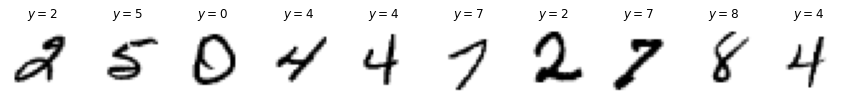

In [ ]:
num_images = 10
fig, axes = plt.subplots(figsize=(1.5*num_images, 1.5), ncols=num_images)

# replace: Whether the sample is with or without replacement. 
# Default is True, meaning that a value of a can be selected multiple times.
sample_ids = np.random.choice(train_images.shape[0], size=num_images, replace=False)

for i, s in enumerate(sample_ids):
    axes[i].imshow(train_images[s,:,:,0], cmap='binary')
    axes[i].set_title("$y = {}$".format(train_labels[s]))
    axes[i].axis('off')
plt.show()

### <center>Small detour: Choosing Colormaps `cmap` in Matplotlib</center>

<img style="float: ;" src="https://matplotlib.org/3.4.3/_images/sphx_glr_colormaps_003.png" width=500 height=350>

(Image Source: [Choosing Colormaps in Matplotlib](https://matplotlib.org/devdocs/tutorials/colors/colormaps.html))

**Data visualisation**: we note that the training set is relatively balanced—there are roughly 6000 examples for each digit.

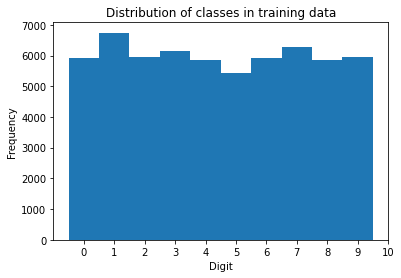

In [ ]:
plt.hist(train_labels, bins=range(11), align='left')
plt.xticks(ticks=range(11))
plt.title('Distribution of classes in training data')
plt.ylabel('Frequency')
plt.xlabel('Digit')
plt.show()

## 2. Multilayer perceptron

The handwritten digit recognition task is an example of a _multi-class_ classification problem. 
There are 10 classes—one for each digit $0, 1,\ldots, 9$.

We need to define 10 output units in the output layer and apply a softmax activation function to generate probability distribution of the classes


This MLP model can be expressed in Keras as follows.

In [ ]:
# Create the MLP model
mlp = keras.Sequential(
    [
        layers.Input((28,28,1)),               # Tell Keras the shape of the input array (a single-channel 28×28 image)
        layers.Flatten(),                      # Unravel/flatten the input array
        layers.Dense(16, activation='relu'),   # Add a fully-connected layer with 16 units and ReLU activation function as the hidden layer
        layers.Dense(10, activation='softmax') # Add a fully-connected layer with a softmax activation function
    ]
)


2022-08-15 23:01:32.957805: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-15 23:01:32.958945: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### <center>Small detour: Softmax & ReLU</center>
<img style="float: left ;" src="https://pic3.zhimg.com/80/v2-998ddf16795db98b980443db952731c2_1440w.jpg?source=1940ef5c" width=400 height=250>
<img style="float: right;" src="https://miro.medium.com/max/357/1*oePAhrm74RNnNEolprmTaQ.png" width=300 height=230>

(Image Source: [programmersought.com](https://www.programmersought.com/article/58194026613/), [Medium](https://medium.com/@kanchansarkar/relu-not-a-differentiable-function-why-used-in-gradient-based-optimization-7fef3a4cecec))

Next, we have to specify a loss function. We use categorial [cross entropy](https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class) for this task. We use [Adam](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam) (Adaptive Moment Estimation) as the optimisation algorithm to update weights of the network and directs Keras to keep track of accuracy during training.

In [ ]:
# Configure the model
mlp.compile(optimizer='adam',
           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
           # use SparseCategoricalCrossentropy because labels are integers. 
           # If the labels are one-hot representation, please use CategoricalCrossentropy loss.
           metrics=['accuracy'])


We're now ready to fit the `mlp` model using the training data. 
By setting `batch_size = 100`, each gradient descent step is computed w.r.t. a random batch of 100 training instances.
By setting `epochs = 20`, we loop over the complete training data 20 times.

In [ ]:
# Start training
history_mlp = mlp.fit(train_images, train_labels, epochs=20, batch_size=100, 
                      validation_split=0.2)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-08-15 23:01:33.065782: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


447/480 [==========================>...] - ETA: 0s - loss: 1.1483 - accuracy: 0.6600WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fddf4c67280> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
480/480 [==============================] - 1s 1ms/step - loss: 1.1157 - accuracy: 0.6708 - val_loss: 0.3330 - val_accuracy: 0.9086
Epoch 2/20
480/480 [==========

The plots below show that the model fit is unlikely to improve significantly with further training. 
Both the test loss and accuracy have flattened out.

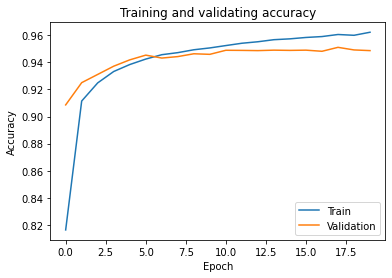

In [ ]:
plt.plot(history_mlp.history['accuracy'], label='Train')
plt.plot(history_mlp.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and validating accuracy')
plt.legend()
plt.show()

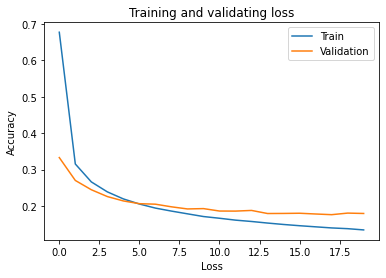

In [ ]:
plt.plot(history_mlp.history['loss'], label='Train')
plt.plot(history_mlp.history['val_loss'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Loss')
plt.title('Training and validating loss')
plt.legend()
plt.show()

However, all of these observations were based on validation data. The best way to test it is to use the actual data generated earlier:

### Evaluate model performance

In [ ]:
# Test the model after training
test_results = mlp.evaluate(test_images, test_labels)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

313/313 [==============================] - 0s 478us/step - loss: 0.1712 - accuracy: 0.9521
Test results - Loss: 0.17119798064231873 - Accuracy: 0.9520999789237976%


Similar result? That's great :)
### Make a prediction

***Re-run cell to see different test examples***

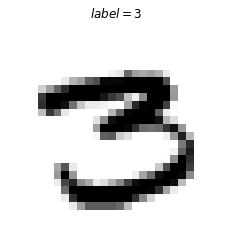

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
probability for the test sample is 0 : 2.7566948e-05
probability for the test sample is 1 : 1.3415014e-06
probability for the test sample is 2 : 0.012840704
probability for the test sample is 3 : 0.9867785
probability for the test sample is 4 : 6.4788837e-13
probability for the test sample is 5 : 0.00031894268
probability for the test sample is 6 : 4.8262783e-11
probability for the test samp

In [ ]:
sample_id = np.random.choice(test_images.shape[0])
digit = test_images[sample_id]

plt.imshow(digit.squeeze(), cmap="binary")
plt.title("$label = {}$".format(test_labels[sample_id]))
plt.axis('off')
plt.show()

# make a prediction for the test sample
digit = np.reshape(digit, (-1, 28*28))

predict_digit = mlp.predict(digit)

for index, i in enumerate(predict_digit[0]):
    print ("probability for the test sample is", index, ":",i)

print("------")   
# The predicted digit (with the highest probability value)
print("The predicted digit:",np.argmax(mlp.predict(digit, verbose=0)))

Notice that we use the Softmax activation function in the output layer, so `predict_digit` returns a 1D tensor with 10 elements, corresponding to the probability values of each category. The predicted digit has the highest probability value.

### Summary

1. Create model: `mdl = keras.Sequential()`
2. Configuration: `mdl.compile(optimizer, loss, metrics)`
3. Train: `history = mdl.fit(x_train, y_train, epochs, batch_size, validation_split)`
4. Predict: `mdl.predict(test_instance)`

We can get a useful summary, including output shape and number of parameters  of the model architecture using the `summary()` method, as shown below.

**Exercise**: Try to  compute the parameters of each layer yourself. Note that if you don't count bias, there could be some difference compare with the summary output number (with bias in a layer, the additional NO. parameters is the NO. filters in the layer).

In [ ]:
mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                12560     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                170       
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
_________________________________________________________________


`dense`: $784\times16+16 = 12560$ (784 channels in, 16 channels out, plus bias).

`dense_1`: $16\times10+10 = 170$ (16 channels in, 10 channels out, plus bias).

**Total params**: $12560+170 = 12730$

*Remember: transformation layers (flatten, pooling, etc.) don't have parameters!*

## 3. Convolutional Neural Network with standard 2D convolution 

Let's now construct a CNN with standard 2D convolution with the following structures for classification on the MNIST dataset.

| Number | Layer type    | Specification                                                                           | Keras function |
|--------|---------------|-----------------------------------------------------------------------------------------|----------------|
| 1      | Convolutional | 8 5×5 filters with a stride of 1 and a ReLU activation function                         | `Conv2D()`         |
| 2      | Pooling       | Max pooling with a 2×2 filter and a stride of 2 (implies pooled regions do not overlap) | `MaxPooling2D()`   |
| 3      | Convolutional | 16 5×5 filters with a stride of 1 and a ReLU activation function                        | `Conv2D()`         |
| 4      | Pooling       | Same specs as pooling layer #1                                                          | `MaxPooling2D()`   |
| 5      | Flatten       | Nil                                                                                     | `Flatten()`        |        |
| 6      | Dense         | 10 units (one for each target class) with a softmax activation function.                | `Dense()`          |



### Exercise 2

Complete the code block below to instantiate the model in Keras. 

Hint: check keras documents for usages of the layers, e.g., how to set the hyperparameters.

* 2D convolutional layer: [`layers.Conv2D()`](https://keras.io/api/layers/convolution_layers/convolution2d/)

* 2D Maxpooling layer: [`layers.MaxPooling2D()`](https://keras.io/api/layers/pooling_layers/max_pooling2d/)


In [ ]:
cnn = keras.Sequential(
    [
        layers.Input((28, 28, 1)),
        
        layers.Conv2D(8, (5, 5), activation='relu'), # fill in
        layers.MaxPooling2D((2, 2)), # fill in
        layers.Conv2D(16, (5, 5), activation='relu'), #fill in
        layers.MaxPooling2D((2, 2)), # fill in
        
        layers.Flatten(),
        layers.Dense(10, activation='softmax')
    ], 
)

Compile and training the model as before

In [ ]:
cnn.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['accuracy'])

Training the `cnn` model takes longer than training the `mlp` model on a CPU. 
You may like to set the number of epochs to a smaller number (e.g. `epochs=10`) if you don't have much time to spare.

In [ ]:
history_cnn = cnn.fit(train_images, train_labels, epochs=10, batch_size=100, 
                      validation_split=0.2)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
475/480 [============================>.] - ETA: 0s - loss: 0.9007 - accuracy: 0.7490WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fddf4a42940> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the ful

Let's plot the accuracy and loss for each epoch

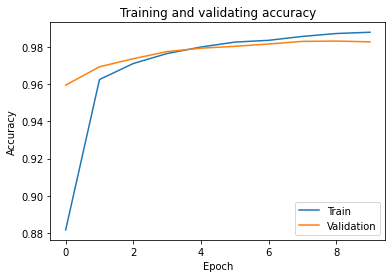

In [ ]:
plt.plot(history_cnn.history['accuracy'], label='Train')
plt.plot(history_cnn.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and validating accuracy')
plt.legend()
plt.show()

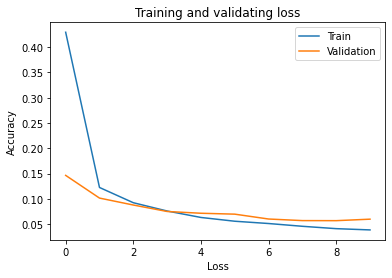

In [ ]:
plt.plot(history_cnn.history['loss'], label='Train')
plt.plot(history_cnn.history['val_loss'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Loss')
plt.title('Training and validating loss')
plt.legend()
plt.show()

We can get a useful summary, including output shape and number of parameters  of the model architecture using the `summary` method, as shown below.
* Try to  compute the parameters of each layer yourself. Note that if you donot count bias, there could be some difference compare with the summary output number (with bias in a layer, the additional NO. parameters is the NO. filters in the layer).

In [ ]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 8)         208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          3216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 5,994
Trainable params: 5,994
Non-trainable params: 0
____________________________________________________

* `conv2d`: $1 \times 8 \times 5 \times 5 +8$ (1 channels in, 8 channels out, $5 \times 5$ convolutional kernel). 
* `conv2d_1`: $8 \times 16 \times 5 \times 5 + 16$ (8 channels in, 16 channels out, $5 \times 5$ convolutional kernel).
* `dense_2`: $256 \times 10 + 10$ (Flatten image and feed to fully connected layer w/ 10 output classes).
* Total params: $208+3216+2570 = 5994$


***
**Question:** How does  `cnn` model compare with  the earlier `mlp` model in terms of number of parameters and testing accuracy ?
***


The NO. parameters of cnn is smaller than the mlp model, but the accuracies are higher.

## 4. Visualize Filters and Feature Maps in CNN

We will discover how to develop simple visualizations for filters and feature maps in a CNN. We'll be using the [VGG16 model](https://keras.io/api/applications/vgg/#vgg16-function) provided by Keras, trained on the ImageNet dataset. For more information on the VGG16, see the [paper](https://arxiv.org/abs/1409.1556).

This section draws heavily on [Jason Brownlee](https://machinelearningmastery.com/)‘s work.

### Load a VGG16 model loaded with pre-trained ImageNet weights

If this is the first time that you have loaded the model, the weights will be downloaded from the internet and may take a moment to download depending on the speed of your internet connection.

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

# load the model
model = VGG16()
# summarize the model
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Now that we have a pre-trained model, we can use it as the basis for visualizations.

### Visualize Filters

#### Summarize the model filters with `model.layers`
We can access all of the layers of the model via the `model.layers` property.

Each layer has a `layer.name` property, where the convolutional layers have a naming convolution like `block#_conv#`, where the `#` is an integer. Therefore, we can check the name of each layer and skip any that don’t contain the string `conv`.

Each convolutional layer has two sets of weights. One is the block of filters and the other is the block of bias values. These are accessible via the `layer.get_weights()` function. We can retrieve these weights and then summarize their shape.

In [ ]:
# summarize filter shapes
for layer in model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

block1_conv1 (3, 3, 3, 64)
block1_conv2 (3, 3, 64, 64)
block2_conv1 (3, 3, 64, 128)
block2_conv2 (3, 3, 128, 128)
block3_conv1 (3, 3, 128, 256)
block3_conv2 (3, 3, 256, 256)
block3_conv3 (3, 3, 256, 256)
block4_conv1 (3, 3, 256, 512)
block4_conv2 (3, 3, 512, 512)
block4_conv3 (3, 3, 512, 512)
block5_conv1 (3, 3, 512, 512)
block5_conv2 (3, 3, 512, 512)
block5_conv3 (3, 3, 512, 512)


We can see that all convolutional layers use 3×3 filters.

We can see that for the input image with three channels for red, green and blue, each filter has a depth of three (here we are working with a channel-last format). We could visualize one filter as a plot with three images, one for each channel, or compress all three down to a single colour image, or even just look at the first channel and assume the other channels will look the same. The problem is that we have 63 other filters we might like to visualize.

We can retrieve the filters from the first layer as follows:

In [ ]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[1].get_weights()

The weight values will likely be small positive and negative values centered around 0.0.

We can normalize their values to the range 0-1 to make them easy to visualize.

In [ ]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

We will be visualising the first six filters out of 64 filters from 1st layer, and plot each of the three channels of each filter. One row for each filter and one column for each channel.

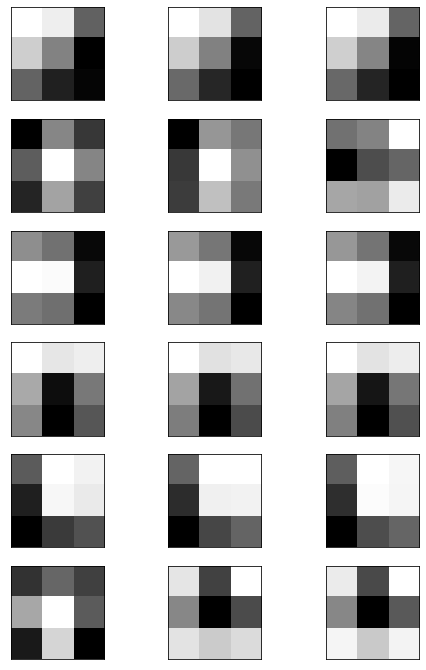

In [ ]:
# plot first few filters
n_filters, ix = 6, 1

fig = plt.figure(figsize=(8, 12))
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # subplot for 6 filters and 3 channels
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1
# plot the filters
plt.show()

We can see that in some cases, the filter is the same across the channels (the first row), and in others, the filters differ (the last row).

The dark squares indicate small or inhibitory weights and the light squares represent large or excitatory weights. Using this intuition, we can see that the filters on the first row detect a gradient from light in the top left to dark in the bottom right.


### Visualize Feature Maps

The activation maps, called feature maps, capture the result of applying the filters to input, such as the input image or another feature map.

We need a clearer idea of the shape of the feature maps output by each of the convolutional layers and the layer index number so that we can retrieve the appropriate layer output. The block below will enumerate all layers in the model and print the output size or feature map size for each convolutional layer as well as the layer index in the model.

In [ ]:
# summarize feature map shapes
for i in range(len(model.layers)):
    layer = model.layers[i]
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # summarize output shape
    print(i, layer.name, layer.output.shape)

1 block1_conv1 (None, 224, 224, 64)
2 block1_conv2 (None, 224, 224, 64)
4 block2_conv1 (None, 112, 112, 128)
5 block2_conv2 (None, 112, 112, 128)
7 block3_conv1 (None, 56, 56, 256)
8 block3_conv2 (None, 56, 56, 256)
9 block3_conv3 (None, 56, 56, 256)
11 block4_conv1 (None, 28, 28, 512)
12 block4_conv2 (None, 28, 28, 512)
13 block4_conv3 (None, 28, 28, 512)
15 block5_conv1 (None, 14, 14, 512)
16 block5_conv2 (None, 14, 14, 512)
17 block5_conv3 (None, 14, 14, 512)


We can use this information and design a new model that is a subset of the layers in the full VGG16 model. The model would have the same input layer as the original model, but the output would be the output of a given convolutional layer, which we know would be the activation of the layer or the feature map.

For example, after loading the VGG model, we can define a new model that outputs a feature map from the first convolutional layer (index 1) as follows.

In [ ]:
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[1].output)

After defining the model, we need to load the image with the size expected by the model, in this case, 224×224.

### Exercise 3: Try replacing it with the image of your choice
Download your favourite photo and place it in your current working directory with the filename `harry.png`.

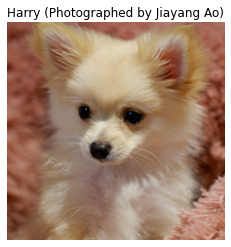

In [ ]:
# load the image with the required shape
img = load_img('./harry.png', target_size=(224, 224))

plt.imshow(img)
plt.title("Harry (Photographed by Jiayang Ao)")
plt.axis('off')
plt.show()

# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = np.expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)

We are now ready to get the feature map. We can do this easy by calling the `model.predict()` function and passing in the prepared single image.

We know the result will be a feature map with 224x224x64. We can plot all 64 two-dimensional images as an 8×8 square of images.

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


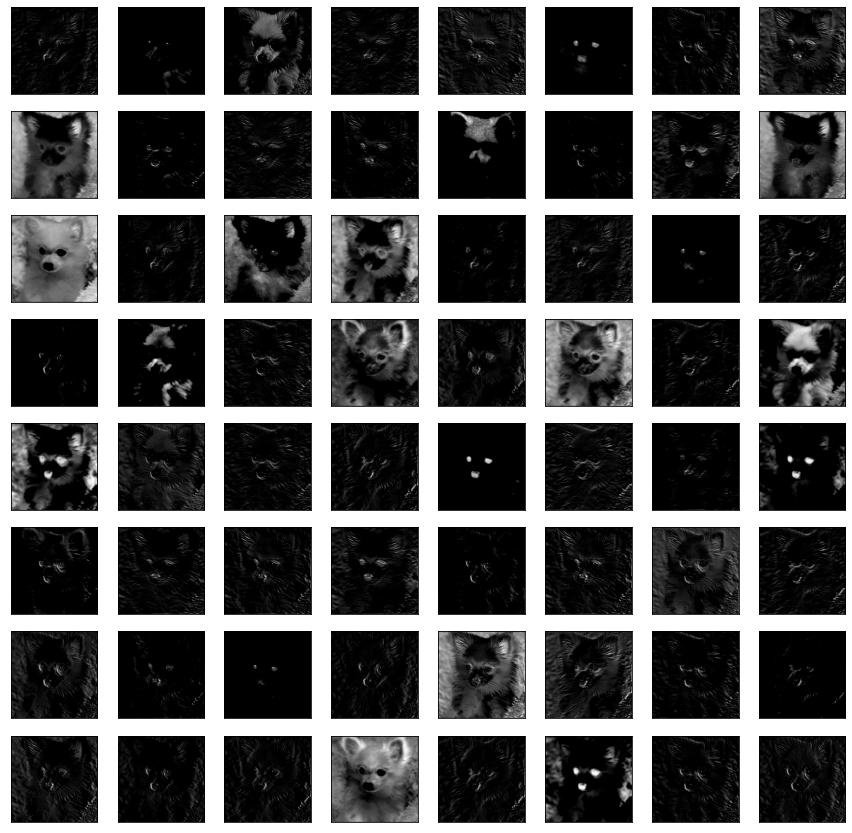

In [ ]:
# get feature map for first hidden layer
feature_maps = model.predict(img)


fig = plt.figure(figsize=(15,15))
# plot all 64 maps in an 8x8 squares
square = 8
for i in range(1, square*square+1):
    # specify subplot and turn of axis
    ax = plt.subplot(square,square,i)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot feature maps in grayscale
    plt.imshow(feature_maps[0,:,:,i-1] , cmap='gray')

# plot all feature maps   
plt.show()

## Bonus: Convolutional neural network with depthwise separable convolution 

### Bonus Exercise 

Construct a CNN with the previous architecture (same output size of feature maps in each layer), except that the standard 2D convolution is replaced  with depthwise separable convolution 

Complete the code block below to instantiate the model in Keras. 

***Hint: check keras documents for usages of the layers, e.g., how to set the hyperparameters.***

- SeparableConv2D layer: [`layers.SeparableConv2D()`](https://keras.io/api/layers/convolution_layers/separable_convolution2d/)


In [ ]:
cnn_ds = keras.Sequential(
    [
        layers.Input((28, 28, 1)),
        layers.SeparableConv2D( 8,(5, 5),activation='relu'), # fill in
        layers.MaxPooling2D((2, 2)), # fill in
        layers.SeparableConv2D(16,(5, 5),  activation='relu'), #fill in
        layers.MaxPooling2D((2, 2)), # fill in
        
    
        layers.Flatten(),
        layers.Dense(10, activation='softmax')
    ], 
)

Compile and training as before

In [ ]:
cnn_ds.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['accuracy'])

history_cnn_ds = cnn_ds.fit(train_images, train_labels, epochs=5, batch_size=100, validation_split=0.2)

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
479/480 [============================>.] - ETA: 0s - loss: 1.3026 - accuracy: 0.5784WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fde1080ca60> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full

We can get a useful summary, including output shape and number of parameters  of the model architecture using the `summary` method, as shown below.
* Try to  compute the parameters of each layer yourself. Note that if you donot count bias, there could be some difference compare with the summary output number (with bias in a layer, the additional NO. parameters is the NO. filters in the layer).

In [ ]:
cnn_ds.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d (SeparableC (None, 24, 24, 8)         41        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 8)         0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 8, 8, 16)          344       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 2,955
Trainable params: 2,955
Non-trainable params: 0
____________________________________________________

* `separable_conv2d`: $5  \times 5 \times 1 + 1\times 1\times 8 +8 $ (Depthwise convolution: Each 5x5 kernel iterates 1 channel of the image; Pointwise Convolution: uses 8 1x1 kernel). 
* `separable_conv2d_1`: $5  \times 5 \times 8 + 1\times 1\times 8 \times 16 + 16 $ (Depthwise convolution: Each 5x5 kernel iterates 8 channel of the image; Pointwise Convolution: uses 16 1x1x8 kernel).
* `dense_3`: $256 \times 10 + 10$ (Flatten image and feed to fully connected layer w/ 10 output classes)
* Total params: $41+344+2570=2955$

***
**Question:** How does  `cnn_ds` model compare with  the earlier `cnn` model in terms of number of parameters and testing accuracy ?
***

The NO. parameters in  `cnn_ds`  is smaller than `cnn`, and the accuracies are similar.

Note: the running time of `cnn_ds` is larger. The efficiency of separable convolution is more obvious with large kernel sizes and more input channels,  because of the overhead involving doing separable convolution and pointwise convolution might be larger than the speedups.